<a href="https://colab.research.google.com/github/be1le/machine-learning/blob/main/Sign_Language_MNIST%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝에서 실행 속도를 더 빠르게 하는 방법

지금까지는 CPU를 사용했는데 GPU를 사용하면 딥러닝의 연산속도를 대폭 향상시킬 수 있습니다!

[런타임] - [런타임 유형 변경] - 하드웨어 가속기 GPU 선택 저장

# 데이터셋 다운로드

영어 알파벳 수화 데이터셋

https://www.kaggle.com/datamunge/sign-language-mnist

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'lildeveloper' # username
os.environ['KAGGLE_KEY'] = '462332910828bbffd4c0cc546c589d3f' # key

In [ ]:
 !kaggle datasets download -d datamunge/sign-language-mnist

sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip sign-language-mnist.zip

y
Archive:  sign-language-mnist.zip
replace amer_sign2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: amer_sign2.png          
replace amer_sign3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: amer_sign3.png          y
y

replace american_sign_language.PNG? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: american_sign_language.PNG  y
y

replace sign_mnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: sign_mnist_test.csv     y
y

replace sign_mnist_test/sign_mnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: sign_mnist_test/sign_mnist_test.csv  
replace sign_mnist_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: sign_mnist_train.csv    
replace sign_mnist_train/sign_mnist_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: sign_mnist_train/sign_mnist_train.csv  


# 패키지 로드

In [ ]:
from tensorflow.keras.models import Model #functional API사용 으로모델 임포트
from tensorflow.keras.layers import Input, Dense # 펑셔널 사용으로 input도 만들어주고
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split#데이터 분리
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 데이터셋 로드

In [ ]:
train_df = pd.read_csv('sign_mnist_train.csv') #트레인데이터셋에 저장해준다. 

train_df.head() #라벨은 숫자로 알파벳순서대로~ 좀있다가 원핫인코딩을 해야한다. 

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [ ]:
test_df = pd.read_csv('sign_mnist_test.csv')  #이건 테스트 데이터셋! test.csv!

test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


# 라벨 분포
- 9=J or 25=Z 는 동작이 들어가므로 제외
- 총 24개의 라벨

In [ ]:
plt.figure(figsize=(14, 10)) #그래프 사이즈 
sns.countplot(train_df['label'])
plt.show()

NameError: ignored

# 전처리

## 입력과 출력 나누기

In [ ]:
train_df = train_df.astype(np.float32) # 학습시키려면 소수점32비트~!
x_train = train_df.drop(columns=['label'], axis=1).values #라벨만 빼주고 나머지feature가 다들어간다. 
y_train = train_df[['label']].values #.values하면 np.array로 바꿔줍니다!

test_df = test_df.astype(np.float32)
x_test = test_df.drop(columns=['label'], axis=1).values
y_test = test_df[['label']].values

print(x_train.shape, y_train.shape)#트레이닝데이터셋은 27455학습시키는 데이터셋 784는픽셀의크기!
#트레이닝 데이터의 입력 노드의 개수가 784개!
print(x_test.shape, y_test.shape)#테스터 데이터셋은 7172학습시키는 데이터셋
#출력값은 1! 라벨하나만 분류해내면 되니까!

(27455, 784) (27455, 1)
(7172, 784) (7172, 1)


## 데이터 미리보기

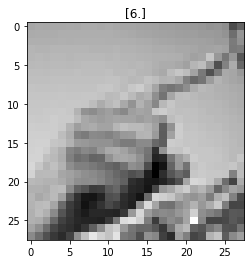

In [ ]:
index = 1
plt.title(str(y_train[index]))
plt.imshow(x_train[index].reshape((28, 28)), cmap='gray') #reshape을해주고 gray로 뿌려라!
plt.show()

## One-hot encoding

In [ ]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()#원핫인코딩은 핏트렌스폼~
y_test = encoder.fit_transform(y_test).toarray()
#보면 y출력이 24가된다 1에서!
print(y_train.shape)

(27455, 24)


## 일반화

이미지 데이터는 픽셀이 0-255 사이의 정수(unsigned integer 8bit = uint8)로 되어 있습니다. 이것을 255로 나누어 0-1 사이의 소수점 데이터(floating point 32bit = float32)로 바꾸고 일반화 시키도록 할게요!

In [ ]:
x_train = x_train / 255. #255로나누는 이유는 이미지데이터의픽셀이 255가 최대이기 때문에
x_test = x_test / 255. #이거두번나누면 엄청작아지니 한번만실행!

# 네트워크 구성

In [ ]:
input = Input(shape=(784,))
hidden = Dense(1024, activation='relu')(input) #노드의개수가 1024
hidden = Dense(512, activation='relu')(hidden)
hidden = Dense(256, activation='relu')(hidden)
output = Dense(24, activation='softmax')(hidden) #24는 26개중 2개안넣어서 그리고 소프트멕스!

model = Model(inputs=input, outputs=output) # functional API를 쓰니까 input과 output정의 

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 24)                6168      
                                                                 
Total params: 1,466,136
Trainable params: 1,466,136
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# 학습

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs = 20
)

Epoch 1/20
858/858 [==============================] - 7s 6ms/step - loss: 1.7280 - acc: 0.4377 - val_loss: 1.2352 - val_acc: 0.5930
Epoch 2/20
858/858 [==============================] - 5s 6ms/step - loss: 0.5824 - acc: 0.7961 - val_loss: 1.0108 - val_acc: 0.7005
Epoch 3/20
858/858 [==============================] - 5s 5ms/step - loss: 0.2672 - acc: 0.9064 - val_loss: 1.0526 - val_acc: 0.6942
Epoch 4/20
858/858 [==============================] - 5s 6ms/step - loss: 0.2023 - acc: 0.9312 - val_loss: 1.2613 - val_acc: 0.7199
Epoch 5/20
858/858 [==============================] - 5s 5ms/step - loss: 0.1393 - acc: 0.9538 - val_loss: 1.1950 - val_acc: 0.7567
Epoch 6/20
858/858 [==============================] - 5s 6ms/step - loss: 0.1100 - acc: 0.9639 - val_loss: 1.1310 - val_acc: 0.7423
Epoch 7/20
858/858 [==============================] - 5s 5ms/step - loss: 0.0914 - acc: 0.9693 - val_loss: 1.2123 - val_acc: 0.7167
Epoch 8/20
858/858 [==============================] - 5s 6ms/step - loss: 0.

# 학습 결과 그래프

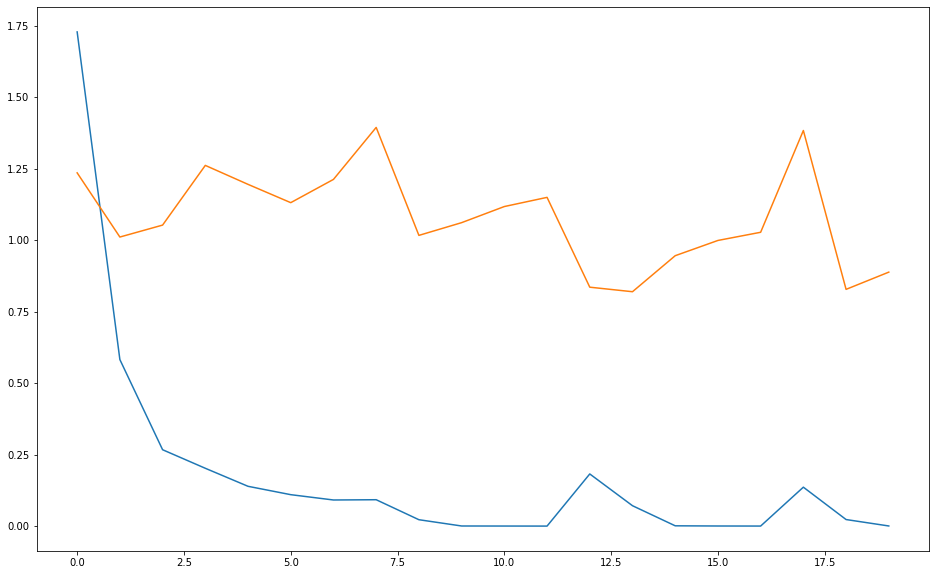

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss']) #히스토리에 학습결과저장 
plt.plot(history.history['val_loss']) # 가로축이 에폭수, 세로축이 정확도가 된다.

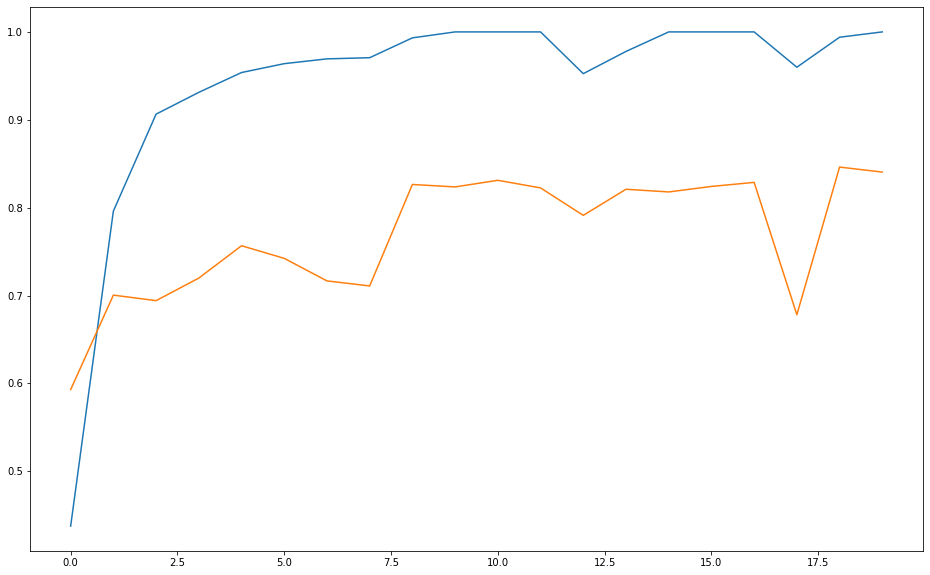

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['acc'])#히스토리에 학습결과저장 
plt.plot(history.history['val_acc']) # 가로축이 에폭수 세로축이 정확도가된다. 